**FaceGan** - Generates 64x64 Face Images

Implemented by Muhammad Hanan Asghar

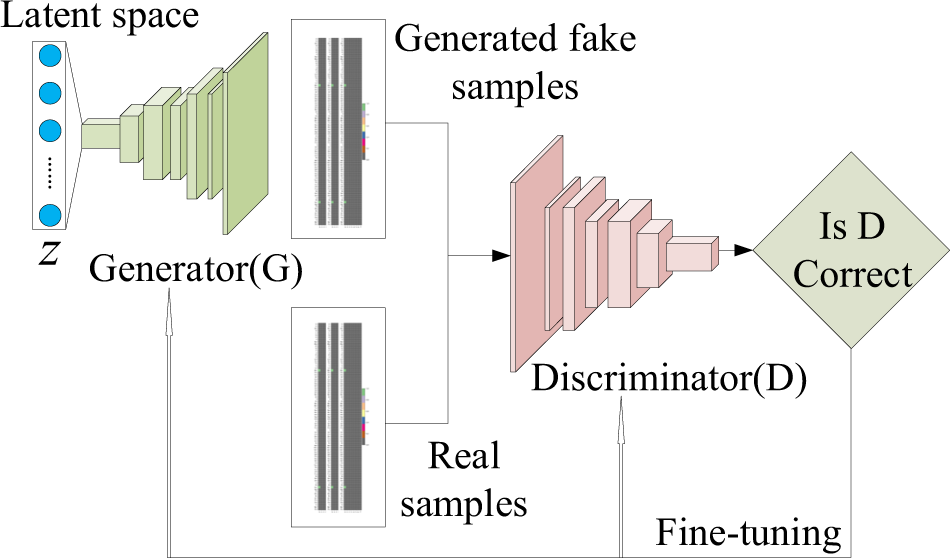

In [ ]:
!nvidia-smi

Fri Jan 21 15:35:54 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.46       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
! pip install -q kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d muhammadhananasghar/faces-dataset

 98% 786M/805M [00:04<00:00, 235MB/s]
100% 805M/805M [00:04<00:00, 202MB/s]


In [ ]:
!unzip *.zip && rm -rf *.zip

In [ ]:
def imShow(image):
  import matplotlib.pyplot as plt
  import cv2
  %matplotlib inline

  image_read = cv2.imread(image)
  height, width = 224, 224
  resized_image = cv2.resize(image_read, (height, width), interpolation=cv2.INTER_CUBIC)
  plt.axis("off")
  plt.imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))

In [ ]:
import os

IMAGES = "/content/Faces"
print(len(os.listdir(IMAGES)))

46525


/content/Faces/OTkzMjI5LmpwZw.jpg


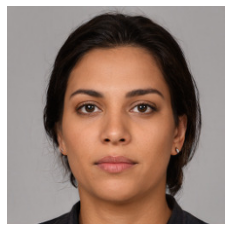

In [ ]:
import random
import os
 
img_path = os.path.join(IMAGES, random.choice(os.listdir(IMAGES)))
print(img_path)
imShow(img_path)

#Importing Libraries

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Reshape, Dropout, Dense 
from tensorflow.keras.layers import Flatten, BatchNormalization
from tensorflow.keras.layers import Activation, ZeroPadding2D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import UpSampling2D, Conv2D, MaxPooling2D,GlobalAveragePooling2D, Conv2DTranspose
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam
import numpy as np
from PIL import Image
from tqdm.notebook import tqdm
import os 
import time
import matplotlib.pyplot as plt

In [ ]:
IMAGE_SIZE = 64
CHANNELS = 3

SEED = 100

# Preview of images during training
PREVIEW_ROWS = 4
PREVIEW_COLS = 7
PREVIEW_MARGIN = 16

IMAGES = "/content/Faces"
EPOCHS = 350
BATCH_SIZE = 64
# Buffer size is set to the total size of dataset
BUFFER_SIZE = len(os.listdir(IMAGES))

In [ ]:
BUFFER_SIZE

46525

In [ ]:
print(f"This GAN will generate {IMAGE_SIZE}px square images.")

This GAN will generate 96px square images.


In [ ]:
# 1=32, 2=64, 3=96. 4=128, 5=224 etc...

#Doing Preprocessing

In [ ]:
import cv2

training_data = []

for filename in tqdm(os.listdir(IMAGES)):
  img_path = os.path.join(IMAGES,filename)
  img_r = cv2.imread(img_path)
  img_res = cv2.resize(img_r, (IMAGE_SIZE, IMAGE_SIZE))
  img_c = cv2.cvtColor(img_res, cv2.COLOR_BGR2RGB)
  training_data.append(img_c)

  0%|          | 0/46525 [00:00<?, ?it/s]

In [ ]:
training_data = np.reshape(training_data, (-1, IMAGE_SIZE, IMAGE_SIZE, CHANNELS))
training_data = training_data.astype(np.float32)
training_data = training_data / 255

In [ ]:
np.save('datafaces_96x.npy', training_data)

In [ ]:
!cp "/content/datafaces_96x.npy" "/content/drive/MyDrive"

^C


In [ ]:
training_data = np.load("datafaces_64x.npy")

In [ ]:
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(training_data).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [ ]:
print(train_dataset)

<BatchDataset shapes: (None, 64, 64, 3), types: tf.float32>


#Generator

In [ ]:
def build_generator(SEED_SIZE):
  noise_shape = (SEED_SIZE,)

  model = Sequential()
  model.add(Dense(4 * 4 * 64, activation="relu", input_shape=noise_shape))
  model.add(Reshape((4, 4, 64)))
  model.add(BatchNormalization(momentum=0.8))
  # After this layer fake image size 4 x 4 x 64

  model.add(UpSampling2D()) #This layer doubles the resolution
  model.add(Conv2D(1024, (3, 3), padding="same"))
  model.add(Activation("relu"))
  model.add(BatchNormalization(momentum=0.8))
  # After this layer 8 x 8 x 1024

  model.add(UpSampling2D()) #This layer doubles the resolution
  model.add(Conv2D(512, (3, 3), padding="same"))
  model.add(Activation("relu"))
  model.add(BatchNormalization(momentum=0.8))
  # After this layer 16 x 16 x 512

  model.add(UpSampling2D()) #This layer doubles the resolution
  model.add(Conv2D(256, (3, 3), padding="same"))
  model.add(Activation("relu"))
  model.add(BatchNormalization(momentum=0.8))
  # After this layer 32 x 32 x 256

  model.add(UpSampling2D()) #This layer doubles the resolution
  model.add(Conv2D(512, (3, 3), padding="same"))
  model.add(Activation("relu"))
  model.add(BatchNormalization(momentum=0.8))
  # After this layer 64 x 64 x 512

  model.add(Conv2D(128, (3, 3), padding="same"))
  model.add(Activation("relu"))
  model.add(BatchNormalization(momentum=0.8))
  # After this layer 64 x 64 x 128

  model.add(Conv2D(32, (3, 3), padding="same"))
  model.add(Activation("relu"))
  model.add(BatchNormalization(momentum=0.8))
  # After this layer 64 x 64 x 32

  model.add(Conv2D(3, (3, 3), padding="same"))
  model.add(Activation("sigmoid")) # because == /255 if /127.5 - 1. then use tanh
  # After this layer 64 x 64 x 3

  # model.summary()
  return model



#Discriminator

In [ ]:
def build_discriminator(image_shape):
  
  model = Sequential()
  # 64, 64, 3
  model.add(Conv2D(32, (3, 3), strides=2, padding="same", input_shape=image_shape))
  model.add(LeakyReLU(alpha=0.2))
  # After this 32 x 32 x 32

  model.add(Dropout(rate=0.25))
  model.add(Conv2D(64, (3, 3), strides=2, padding="same"))
  model.add(LeakyReLU(alpha=0.2))
  model.add(BatchNormalization(momentum=0.8))
  # After this 16 x 16 x 64

  model.add(Dropout(rate=0.25))
  model.add(Conv2D(128, (3, 3), strides=1, padding="same"))
  model.add(LeakyReLU(alpha=0.2))
  model.add(BatchNormalization(momentum=0.8))
  # After this 8 x 8 x 128

  model.add(Dropout(rate=0.25))
  model.add(Conv2D(256, (3, 3), strides=1, padding="same"))
  model.add(LeakyReLU(alpha=0.2))
  model.add(BatchNormalization(momentum=0.8))
  # After this 4 x 4 x 256

  model.add(Flatten()) # 4 * 4 *256

  model.add(Dense(512))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Dropout(0.2))

  model.add(Dense(1))
  model.add(Activation("sigmoid"))

  # model.summary()

  return model

In [ ]:
generator = build_generator(SEED)

In [ ]:
def imShow(image):
  import matplotlib.pyplot as plt
  import cv2
  %matplotlib inline

  height, width = 64, 64
  resized_image = cv2.resize(image, (height, width), interpolation=cv2.INTER_CUBIC)
  plt.axis("off")
  plt.imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))

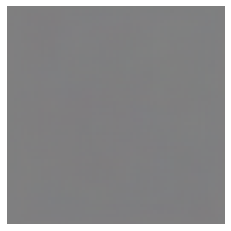

In [ ]:
noise = tf.random.normal([1, SEED])
generated_image = generator(noise, training=False)

imShow(generated_image[0].numpy())

In [ ]:
image_shape = (IMAGE_SIZE,IMAGE_SIZE,CHANNELS)
 
discriminator = build_discriminator(image_shape)
decision = discriminator(generated_image)

In [ ]:
print(decision)

tf.Tensor([[0.49636322]], shape=(1, 1), dtype=float32)


#Losses

In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

#Optimizers

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(1.5e-4,0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(1.5e-4,0.5)

#Saving

In [ ]:
def save_images(cnt,noise):
  image_array = np.full(( 
      PREVIEW_MARGIN + (PREVIEW_ROWS * (IMAGE_SIZE+PREVIEW_MARGIN)), 
      PREVIEW_MARGIN + (PREVIEW_COLS * (IMAGE_SIZE+PREVIEW_MARGIN)), 3), 
      255, dtype=np.uint8)
  
  generated_images = generator.predict(noise)
 
  #generated_images = 0.5 * generated_images + 0.5
 
  image_count = 0
  for row in range(PREVIEW_ROWS):
      for col in range(PREVIEW_COLS):
        r = row * (IMAGE_SIZE+16) + PREVIEW_MARGIN
        c = col * (IMAGE_SIZE+16) + PREVIEW_MARGIN
        image_array[r:r+IMAGE_SIZE,c:c+IMAGE_SIZE] = generated_images[image_count] * 255
        image_count += 1
 
  filename = os.path.join("/content/drive/MyDrive/GAN/output",f"train-{cnt}.png")
  im = Image.fromarray(image_array)
  im.save(filename)
  if int(cnt)%5 == 0:
    generator.save(os.path.join('/content/drive/MyDrive/GAN/model', f"train-{cnt}.h5"))
    print("Saved Infrences at {}.".format(cnt))

#Training

In [ ]:
@tf.function
def train_step(images):
  seed = tf.random.normal([BATCH_SIZE, SEED])
  # GradientTape make generator and discriminator trains together
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    # Generate Fake Image from generator
    generated_images = generator(seed, training=True)
    # Training real dataset images in discriminator
    real_output = discriminator(images, training=True)
    # Training generator generated images in discriminator
    fake_output = discriminator(generated_images, training=True)
    # Calculate Generator loss
    gen_loss = generator_loss(fake_output)
    # Calculate Discriminator loss
    disc_loss = discriminator_loss(real_output, fake_output)

    # Getting Generator Model Gradients
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    # Getting Discriminator Model Gradients
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    # Updating Generator Model Gradients
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))

    # Updating Discriminator Model Gradients
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

  return gen_loss,disc_loss, real_output, fake_output

In [ ]:
# Creating Training Function
def train(dataset, epochs):
  # Size of image saved during training
  fixed_seed = np.random.normal(0, 1, (PREVIEW_ROWS * PREVIEW_COLS, SEED))
  # Number of Images
  num_of_images = len(os.listdir('Faces'))

  # Start
  for epoch in range(epochs):

    # Defining Variables
    gen_loss_list = []
    disc_loss_list = []
    real_list = []
    fake_list = []

    # Iterating through images
    for image_batch in tqdm(dataset, position=1, leave=True, total = int(num_of_images/BATCH_SIZE)):
      # Training Batch
      t = train_step(image_batch)
      # Saving Data of current batch
      gen_loss_list.append(t[0])
      disc_loss_list.append(t[1])

      real_out = t[2].numpy()
      fake_out = t[3].numpy()

      # If discriminator Real Image output is greater than 0.5 then == 1.
      # If discrimintor Real Image output is less than and equal to 0.5 then == 0.
      real_out[real_out > .5] = 1
      real_out[real_out <= .5] = 0

      # Height and Width of real image
      height, width = real_out.shape[:2]
      real_right = sum(real_out) / (height * width)

      real_list.append(real_right)
      # If discriminator Fake Image output is greater than 0.5 then == 0.
      # If discrimintor Fake Image output is less than and equal to 0.5 then == 1.
      fake_out[fake_out > .5] = 0
      fake_out[fake_out <= .5] = 1

      height, width = fake_out.shape[:2]
      fake_right = sum(fake_out) / (height * width)

      fake_list.append(fake_right)

    # Calculating Losses and Accuracy Average
    g_loss = sum(gen_loss_list) / len(gen_loss_list)
    d_loss = sum(disc_loss_list) / len(disc_loss_list)
    r_acc = sum(real_list) / len(real_list)
    f_acc = sum(fake_list) / len(fake_list)

    print (f'Epoch {epoch+1}, Gen Loss = {g_loss}, Disc Loss = {d_loss}')
    # Saving Image
    save_images(epoch+1,fixed_seed)

In [ ]:
train(train_dataset, 1000)

In [ ]:
import os

images = [os.path.join("/content/drive/MyDrive/GAN/output", img) for img in os.listdir("/content/drive/MyDrive/GAN/output")]
print(images)

['/content/drive/MyDrive/GAN/output/train-1.png', '/content/drive/MyDrive/GAN/output/train-2.png', '/content/drive/MyDrive/GAN/output/train-3.png', '/content/drive/MyDrive/GAN/output/train-4.png', '/content/drive/MyDrive/GAN/output/train-5.png', '/content/drive/MyDrive/GAN/output/train-6.png', '/content/drive/MyDrive/GAN/output/train-7.png', '/content/drive/MyDrive/GAN/output/train-8.png', '/content/drive/MyDrive/GAN/output/train-9.png', '/content/drive/MyDrive/GAN/output/train-10.png', '/content/drive/MyDrive/GAN/output/train-11.png', '/content/drive/MyDrive/GAN/output/train-12.png', '/content/drive/MyDrive/GAN/output/train-13.png', '/content/drive/MyDrive/GAN/output/train-14.png', '/content/drive/MyDrive/GAN/output/train-15.png', '/content/drive/MyDrive/GAN/output/train-16.png', '/content/drive/MyDrive/GAN/output/train-17.png', '/content/drive/MyDrive/GAN/output/train-18.png', '/content/drive/MyDrive/GAN/output/train-19.png', '/content/drive/MyDrive/GAN/output/train-20.png', '/conten

In [ ]:
import os
import moviepy.video.io.ImageSequenceClip
image_folder='/content/drive/MyDrive/GAN/output'
fps=1

image_files = [os.path.join(image_folder,img)
               for img in os.listdir(image_folder)
               if img.endswith(".png")]
clip = moviepy.video.io.ImageSequenceClip.ImageSequenceClip(image_files, fps=fps)
clip.write_videofile('ha_gan.mp4')

[MoviePy] >>>> Building video ha_gan.mp4
[MoviePy] Writing video ha_gan.mp4


 98%|█████████▊| 41/42 [00:01<00:00, 26.89it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ha_gan.mp4 



In [ ]:
import matplotlib.pyplot as plt
import cv2
%matplotlib inline

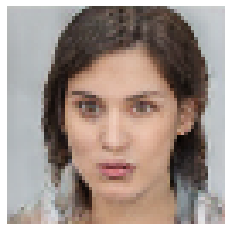

In [ ]:
generator_x = tf.keras.models.load_model("/content/drive/MyDrive/GAN/model/train-40.h5", compile=False)
noise = tf.random.normal([1, SEED])
generated_image = generator_x(noise, training=False)
random_array = generated_image[0].numpy() * 255
random_array = random_array.astype(np.uint8)
random_image = Image.fromarray(random_array)
plt.axis("off")
plt.imshow(random_image)

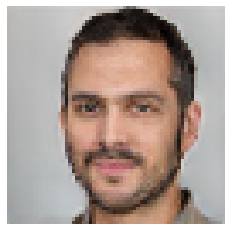